# Image classification using TensorFlow estimators and TensorFlow Hub for transfer learning

*This notebook is available [as a codelab](https://colab.research.google.com/github/damienpontifex/BlogCodeSamples/blob/master/TransferLearning/TfHubDogsVsCats.ipynb)*

TensorFlow Hub was [announced](https://www.youtube.com/watch?v=rirzJ-e68cw) at TensorFlow Dev Summit 2018 and promises to reduce the effort required to use existing machine learning models and weights in your own custom model. From the [overview page](https://www.tensorflow.org/hub/)

> TensorFlow Hub is a library to foster the publication, discovery, and consumption of reusable parts of machine learning models. A module is a self-contained piece of a TensorFlow graph, along with its weights and assets, that can be reused across different tasks in a process known as transfer learning.

Dogs vs Cats is a great classification problem to learn about transfer learning and is the [first lesson of the fast.ai course](http://course.fast.ai/lessons/lesson1.html) and was hosted on Kaggle. The teaching is if you can achieve transfer learning for this two-class problem of cats and dogs, you can do it for any *n*-class problem for your own solution.

### Prerequisites

You will need to install TensorFlow Hub from pip and have at least TensorFlow version 1.7. I'm also assuming you have some understanding (although not required but will be in this code) of TensorFlow and machine learning, mainly:
* Data preparation
* tf.data input
* TensorFlow estimators

To ensure you've got the libraries installed run:

In [ ]:
%%bash 
# pip3 install -qU tensorflow>=1.7.0 # Don't run this on Google's colab as you probably want to use the version they have pre-installed
pip3 install -q tensorflow-hub

Just some usual imports and matplotlib setup for notebooks. And then just print out some information about our TensorFlow environment

In [15]:
import os
from urllib import request
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.python import debug as tf_debug

%matplotlib inline

In [2]:
tf.__version__, tf.test.is_gpu_available(), tf.test.is_built_with_cuda(), tf.test.gpu_device_name()

('1.7.0', False, False, '')

The Dogs vs Cats Kaggle competition is a two-class image classification problem. Transfer learning can be used to reduce the amount of computation and to reuse previously computed features of interest.

For this, we'll look into the new TensorFlow Hub modules to train on our own dataset. First lets just grab, and have a look, at the data we've got.

## Data

We will get the data from the fastai zip of the dogs and cats images. The file pattern on disk is to have each category of images labelled by placing all associated images into one folder. As such, we will have a folder named 'dogs' of all dog images and 'cats' of all cat images to train on.

So that this notebook can be run anywhere, here we are just downloading the archive and placing it in a temporary local data directory

In [3]:
data_dir = '/tmp/datasets/dogscats'

if not os.path.isdir(data_dir):
    # Download the data zip to our data directory and extract
    fallback_url = 'http://files.fast.ai/data/dogscats.zip'
    tf.keras.utils.get_file(
        os.path.join('/tmp', os.path.basename(fallback_url)), 
        fallback_url, 
        cache_dir='/tmp',
        extract=True)

'/tmp/dogscats.zip'

Looking at what is in the data directory

In [5]:
os.listdir(data_dir)

['valid', '.DS_Store', 'test1', 'models', 'sample', 'train']

Look in the valid directory to see the image classes. Here we see we have a folder of dogs and another of cats.

In [6]:
os.listdir(os.path.join(data_dir, 'valid'))

['dogs', 'cats']

In [7]:
cats = os.listdir(os.path.join(data_dir, 'valid', 'cats'))[:5]
cats

['cat.9895.jpg',
 'cat.10145.jpg',
 'cat.11515.jpg',
 'cat.9103.jpg',
 'cat.7890.jpg']

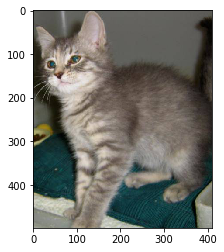

In [8]:
img = plt.imread(os.path.join(data_dir, 'valid', 'cats', cats[0]))
plt.imshow(img)

In [9]:
img.shape

(499, 410, 3)

## tf.data to access our dataset

Our dataset input function is responsible for providing features and labels to the network. We will use a glob pattern via the `file_pattern` parameter to indicate the files on disk and return a dataset to use.

In [10]:
def make_input_fn(file_pattern, image_size=(299, 299), shuffle=False, batch_size=64, num_epochs=None, buffer_size=4096):
    
    def _path_to_img(path):
        # Get the parent folder of this file to get it's class name
        label = tf.string_split([path], delimiter='/').values[-2]
        
        # Read in the image from disk
        image_string = tf.read_file(path)
        image_decoded = tf.image.decode_jpeg(image_string, channels=3)
        # Convert from full range of uint8 to range [0,1] of float32.
        image_decoded_as_float = tf.image.convert_image_dtype(image_decoded, dtype=tf.float32)
        # Resize to expected
        image_resized = tf.image.resize_images(image_decoded_as_float, size=image_size)
        
        return { 'image': image_resized }, label
    
    def _input_fn():
      
        dataset = tf.data.Dataset.list_files(file_pattern)

        if shuffle:
            dataset = dataset.apply(tf.contrib.data.shuffle_and_repeat(buffer_size, num_epochs))
        else:
            dataset = dataset.repeat(num_epochs)

        dataset = dataset.map(_path_to_img, num_parallel_calls=os.cpu_count())
        dataset = dataset.batch(batch_size).prefetch(buffer_size)

        return dataset

    return _input_fn

## Our first model

We're setting up an esimator `model_fn` so we can include the module as the base and then provide our own dense layer and activations to be trained for our use case. We're passing in the module spec (a string) via the `params` dictionary so we could swap out another image classification model easily.

The highlight here for TensorFlow Hub and transfer learning are these lines:

```python
module = hub.Module(params['module_spec'], trainable=is_training, name=params['module_name'])
bottleneck_tensor = module(features['image'])
```

We load up the module and specify whether we would like to fine tune it or not. Then pass in our image tensor to the module and get the output tensor as `bottleneck_tensor` to be used in further layers. If you see a diagram of the structure of some of these models, the simplification of this down to two lines is amazing!

In [11]:
def model_fn(features, labels, mode, params):
    is_training = mode == tf.estimator.ModeKeys.TRAIN

    NUM_CLASSES = len(params['label_vocab'])

    module = hub.Module(params['module_spec'], trainable=is_training, name=params['module_name'])
    bottleneck_tensor = module(features['image'])

    with tf.name_scope('final_retrain_ops'):
        logits = tf.layers.dense(bottleneck_tensor, units=1, trainable=is_training and params['train_module'])

    def train_op_fn(loss):
        optimizer = tf.train.AdamOptimizer(learning_rate=params['learning_rate'])
        return optimizer.minimize(loss, global_step=tf.train.get_global_step())

    if NUM_CLASSES == 2:
        head = tf.contrib.estimator.binary_classification_head(label_vocabulary=params['label_vocab'])
    else:
        head = tf.contrib.estimator.multi_class_head(n_classes=NUM_CLASSES, label_vocabulary=params['label_vocab'])

    return head.create_estimator_spec(
        features, mode, logits, labels, train_op_fn=train_op_fn
    )

Finally, we setup our estimator as per usual:

* Define some hyperparameters
* Construct the estimator
* `train_and_evaluate`

And with that, we get distributed training and great device placement for data processing on the CPU and training on the GPU.

In [20]:
def train(model_directory, data_directory):

    params = {
        'module_spec': 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/1',
        'module_name': 'resnet_v2_50',
        'learning_rate': 1e-3,
        'train_module': False,  # Whether we want to finetune the module
        'label_vocab': os.listdir(os.path.join(data_dir, 'valid'))
    }

    run_config = tf.estimator.RunConfig()

    classifier = tf.estimator.Estimator(
        model_fn=model_fn,
        model_dir=model_directory,
        config=run_config,
        params=params
    )

    input_img_size = hub.get_expected_image_size(hub.Module(params['module_spec']))

    train_files = os.path.join(data_directory, 'train', '**/*.jpg')
    train_input_fn = make_input_fn(train_files, image_size=input_img_size, batch_size=8, shuffle=True)
    train_spec = tf.estimator.TrainSpec(train_input_fn, max_steps=20)

    eval_files = os.path.join(data_directory, 'valid', '**/*.jpg')
    eval_input_fn = make_input_fn(eval_files, image_size=input_img_size, batch_size=1)
    eval_spec = tf.estimator.EvalSpec(eval_input_fn)

    tf.estimator.train_and_evaluate(classifier, train_spec, eval_spec)

In [ ]:
tf.logging.set_verbosity(tf.logging.INFO)
train('/tmp/dogscats/run2', data_dir)

## Conclusion

TensorFlow Hub will significantely increase the approachability for people to use complex models from others for their own specific task. The ability to fine tune while also using as is continues to democritize everyone's use of ML tools.